# ultralytics 다운로드

In [43]:
import os

# HOME=os.getcwd()
HOME='/home/jupyter'
print(HOME)

/home/jupyter


In [56]:
!pip install Pillow==9.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 10.0.1
    Uninstalling Pillow-10.0.1:
      Successfully uninstalled Pillow-10.0.1


In [1]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40354MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 34.1/98.2 GB disk)


In [44]:
from ultralytics import YOLO

from IPython.display import display, Image

In [15]:
# %cd {HOME}
# !git clone https://github.com/ultralytics/ultralytics
# %cd ultralytics

[Errno 2] No such file or directory: '{HOME}'
/home/jupyter
Cloning into 'ultralytics'...
remote: Enumerating objects: 19301, done.
remote: Counting objects: 100% (485/485), done.
remote: Compressing objects: 100% (310/310), done.
remote: Total 19301 (delta 214), reused 350 (delta 174), pack-reused 18816
Receiving objects: 100% (19301/19301), 10.81 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (13401/13401), done.
/home/jupyter/ultralytics


In [16]:
!ls -al

total 168
drwxr-xr-x  9 jupyter jupyter  4096 Nov 23 01:04 .
drwxr-xr-x 17 jupyter jupyter  4096 Nov 23 01:04 ..
drwxr-xr-x  8 jupyter jupyter  4096 Nov 23 01:04 .git
drwxr-xr-x  4 jupyter jupyter  4096 Nov 23 01:04 .github
-rw-r--r--  1 jupyter jupyter  2295 Nov 23 01:04 .gitignore
-rw-r--r--  1 jupyter jupyter  2316 Nov 23 01:04 .pre-commit-config.yaml
-rw-r--r--  1 jupyter jupyter   612 Nov 23 01:04 CITATION.cff
-rw-r--r--  1 jupyter jupyter  5597 Nov 23 01:04 CONTRIBUTING.md
-rw-r--r--  1 jupyter jupyter 34523 Nov 23 01:04 LICENSE
-rw-r--r--  1 jupyter jupyter   200 Nov 23 01:04 MANIFEST.in
-rw-r--r--  1 jupyter jupyter 28854 Nov 23 01:04 README.md
-rw-r--r--  1 jupyter jupyter 27878 Nov 23 01:04 README.zh-CN.md
drwxr-xr-x  2 jupyter jupyter  4096 Nov 23 01:04 docker
drwxr-xr-x 14 jupyter jupyter  4096 Nov 23 01:04 docs
drwxr-xr-x  9 jupyter jupyter  4096 Nov 23 01:04 examples
-rw-r--r--  1 jupyter jupyter  1253 Nov 23 01:04 requirements.txt
-rw-r--r--  1 jupyter jupyter  2016 Nov 

# BUCKET

In [3]:
# 나의 버킷 리스트 보기
!gsutil list

gs://bucket-shinjaen-test/
gs://cloud-ai-platform-667a4942-e822-4d94-9da8-49ac50c05230/
gs://sessac-project-01-bucket/


In [4]:
BUCKET_NAME="gs://bucket-shinjaen-test"

In [5]:
# 버킷 안에 들어있는 파일 확인
!gsutil ls -r {BUCKET_NAME}

gs://bucket-shinjaen-test/highway_yolo.zip


In [6]:
# 버킷 디스크 사용 용량 확인
!gsutil du -s {BUCKET_NAME}

36084737104  gs://bucket-shinjaen-test


In [ ]:
!gsutil cp gs://highway-data-bucket/highway_yolo.zip highway_yolo.zip

In [ ]:
%%time
import zipfile
import multiprocessing
import concurrent.futures

def unzip(file):
    with lock:
        zf.extract(file, path='/home/jupyter')

zipfilePath = '/home/jupyter/highway_yolo.zip'  
zf = zipfile.ZipFile(zipfilePath)    

m = multiprocessing.Manager()
lock = m.Lock()

with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    executor.map(unzip, zf.infolist())

# data structrue

In [45]:
import os
import glob

In [46]:
dataPath = '/home/jupyter/dataset'

In [47]:
# train 개수 확인
a = glob.glob(dataPath+"/train/images/*")
b = glob.glob(dataPath+"/train/labels/*")
len(a), len(b)

(23951, 23040)

In [48]:
# valid 개수 확인
a = glob.glob(dataPath+"/valid/images/*")
b = glob.glob(dataPath+"/valid/labels/*")
len(a), len(b)

(3333, 3208)

In [49]:
os.makedirs(os.path.join(dataPath,'temp'), exist_ok=True)
# exist_ok=True: 이 부분은 디렉터리가 이미 존재하면 에러를 발생시키지 않고 조용히 지나가도록 하는 옵션

In [12]:
import numpy as np
import lxml
import os

from lxml import etree

CLASSES = ["car", "bus", "truck"]

def to_yolov8(y):
  """
  # change to yolo v8 format
  # [x_top_left, y_top_left, x_bottom_right, y_bottom_right] to
  # [x_center, y_center, width, height]
  """
  width = y[2] - y[0]
  height = y[3] - y[1]

  if width < 0 or height < 0:
      print("ERROR: negative width or height ", width, height, y)
      raise AssertionError("Negative width or height")
  return (y[0] + (width/2)), (y[1] + (height/2)), width, height

def load_xml_annotations(f):
  tree = etree.parse(f)
  anns = []
  for dim in tree.xpath("image"):
    image_filename = dim.attrib["name"]
    width = int(dim.attrib["width"])
    height = int(dim.attrib["height"])
    # print(image_filename)
    # print(len(dim.xpath("box")))
    boxes = []
    for box in dim.xpath("box"):
      label = CLASSES.index(box.attrib["label"])
      xtl, ytl = box.attrib["xtl"], box.attrib["ytl"]
      xbr, ybr = box.attrib["xbr"], box.attrib["ybr"]

      xc, yc, w, h = to_yolov8([float(xtl), float(ytl), float(xbr), float(ybr)])
      boxes.append([label, round(xc/width, 5), round(yc/height, 5), round(w/width, 5), round(h/height, 5)])

    anns.append([image_filename, width, height, boxes])

  return np.array(anns)

def write_yolov8_txt(folder, annotation):
  out_filename = str(folder + annotation[0][:-3])
  out_filename = os.path.splitext(out_filename)[0]
  out_filename = out_filename+'.txt'

  f = open(out_filename,"w+")
  for box in annotation[3]:
    f.write("{} {} {} {} {}\n".format(box[0], box[1], box[2], box[3], box[4]))

label_file = os.path.join(dataPath,'Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD.xml')

anns = load_xml_annotations(label_file)
print(anns)
for ann in anns:
  write_yolov8_txt(dataPath + '/temp/', ann)

ModuleNotFoundError: No module named 'lxml'

In [ ]:
anns

In [ ]:
%cd /content/highway/bbox_highway/
!mkdir temp

In [ ]:
dataPath

# 레이블 시각화 하기

In [13]:
dataPath = '/home/jupyter/dataset'

In [17]:
def glob_files(path, file_type="*"):
    search_string = os.path.join(path, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
        if os.path.isdir(f):
            sub_paths = glob_files(f + '/')
            paths += sub_paths
        else:
            paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

In [18]:
import cv2
import numpy as np

IMAGE_SIZE = 600

def load_images(path):
    files = glob_files(path, "*.png")
    
    files.sort() #####
    
    # print(files)
    X_data = []
    for file in files[:10]: ##### 10개만
        image = cv2.imread(file)
        # print(image.shape)
        # x = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

        X_data.append(image)
    return np.array(X_data)

X_test = load_images(dataPath+"/train/images")

In [19]:
X_test.shape

(10, 1920, 1080, 3)

In [20]:
WIDTH = 1080
HEIGHT = 1920

def load_labels(path):
    files = glob_files(path, "*.txt")
    
    files.sort() #####

    Y_data = []
    for file in files[:10]: ##### 10개만
        with open(file) as f:
            lines = f.readlines()

            boxes = []
            for line in lines:
                tokens = line.split()

                class_id = int(tokens[0])
                xc = float(tokens[1]) * WIDTH
                yc = float(tokens[2]) * HEIGHT
                width = float(tokens[3]) * WIDTH
                height = float(tokens[4]) * HEIGHT

                boxes.append(np.array([class_id, xc, yc, width, height]))
                # print(class_id, xc, yc, width, height)

            Y_data.append(np.array(boxes))
        # print(lines)
    return np.array(Y_data, dtype="object")

Y_test = load_labels(dataPath+"/train/labels")

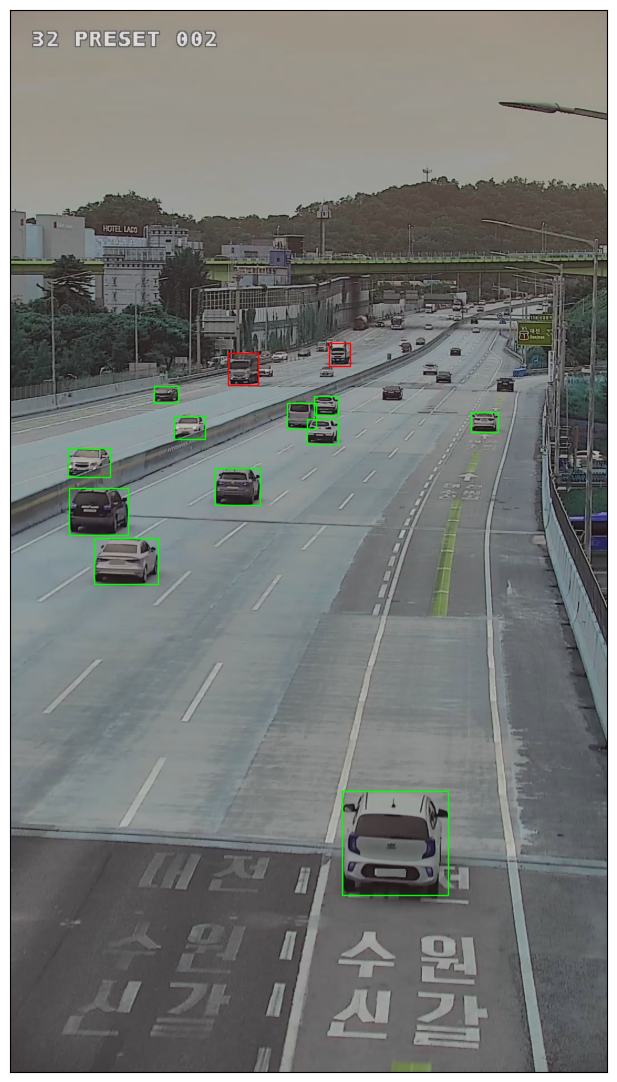

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def create_patch_rectangle(y, color):
  # # in yolov5
  width = int(y[2])
  height = int(y[3])
  return patches.Rectangle((int(y[0] - width/2), int(y[1] - height/2)),
                           width, height,
                           edgecolor=color, fill=False)

COLORS = [(0, 255/255, 0), (255/255, 255/255, 0), (255/255, 0, 0)]

def plot_image(image, boxes, axis):
  # # print(boxes.shape)
  for box in boxes:
    # print(box)
    class_id = int(box[0])
    # print(type(class_id), class_id)
    rect = create_patch_rectangle(box[1:], COLORS[class_id])
    axis.add_patch(rect)

  plt.imshow(image)

def plot_images(X, Y, limit=10):
  fig = plt.figure(figsize=(100, 80))

  last_id = min(limit, X.shape[0])
  for id in range(last_id):
    axis = fig.add_subplot(5, 3, id + 1)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    plot_image(X[id], Y[id], axis)

plot_images(np.array([X_test[-1]]), np.array([Y_test[-1]]))

# 데이터셋 경로 설정

In [22]:
import os
from glob import glob
import torch

trainPath = os.path.join(dataPath,'train')
validPath = os.path.join(dataPath,'valid')
testPath  = os.path.join(dataPath,'test')

trainImagesPath = os.path.join(trainPath, 'images')
validImagesPath = os.path.join(validPath, 'images')
testImagesPath  = os.path.join(testPath,  'images')

trainLabelsPath = os.path.join(trainPath, 'labels')
validLabelsPath = os.path.join(validPath, 'labels')
testLabelsPath  = os.path.join(testPath,  'labels')

In [23]:
trainImagesPath, trainLabelsPath

('/home/jupyter/dataset/train/images', '/home/jupyter/dataset/train/labels')

In [24]:
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} \
    ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.13.1+cu117     (NVIDIA A100-SXM4-40GB)


In [25]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [26]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [27]:
# GPU 이름 체크(cuda:0에 연결된 그래픽 카드 기준)
print(torch.cuda.get_device_name()) # 'NVIDIA TITAN X (Pascal)'

NVIDIA A100-SXM4-40GB


In [28]:
!nvidia-smi

Thu Nov 23 01:06:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Write data.yaml

In [50]:
from IPython.core.magic import register_line_cell_magic

# yaml에 직접 쓰기를 실행하는 함수
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [51]:
dataPath

'/home/jupyter/dataset'

In [52]:
dataYaml = os.path.join(dataPath,'data.yaml')
dataYaml

'/home/jupyter/dataset/data.yaml'

In [53]:
print(trainImagesPath)
print(validImagesPath)
print(testImagesPath)

/home/jupyter/dataset/train/images
/home/jupyter/dataset/valid/images
/home/jupyter/dataset/test/images


In [54]:
%%writetemplate {dataYaml}
train: {trainImagesPath}
val: {validImagesPath}

nc: 3
names: ['car', 'bus', 'truck']

In [34]:
!pip list | grep ultralytics

ultralytics                              8.0.20


In [35]:
# from ultralytics import YOLO

# # Load a model
# model = YOLO('yolov8n.yaml')  # build a new model from YAML
# model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
# model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

# # Train the model
# results = model.train(data=dataYaml, epochs=100, imgsz=640)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

  0%|          | 0.00/6.23M [00:00<?, ?B/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [12

AttributeError: 'YOLO' object has no attribute 'load'

In [45]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8s.yaml')  # build a new model from YAML
# model = YOLO('yolov8s.pt')  # load a pretrained model (recommended for training)
# model = YOLO('yolov8s.yaml').load('yolov8s.pt')  # build from YAML and transfer weights
model = YOLO(f'{HOME}/yolov8n.pt')

# Train the model
results = model.train(data=dataYaml, epochs=10, imgsz=640, batch=32, patience=20, workers=15)

Ultralytics YOLOv8.0.20 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40354MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/jupyter/dataset/data.yaml, epochs=10, patience=20, batch=32, imgsz=640, save=True, cache=False, device=, workers=15, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fals

In [55]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8s.yaml')  # build a new model from YAML
# model = YOLO('yolov8s.pt')  # load a pretrained model (recommended for training)
# model = YOLO('yolov8s.yaml').load('yolov8s.pt')  # build from YAML and transfer weights
model = YOLO(f'{HOME}/yolov8m.pt')


# Train the model
results = model.train(data=dataYaml, epochs=20, imgsz=640, batch=32, patience=20, workers=15)

Ultralytics YOLOv8.0.20 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40354MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/home/jupyter/dataset/data.yaml, epochs=20, patience=20, batch=32, imgsz=640, save=True, cache=False, device=, workers=15, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fal

In [57]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8s.yaml')  # build a new model from YAML
# model = YOLO('yolov8s.pt')  # load a pretrained model (recommended for training)
# model = YOLO('yolov8s.yaml').load('yolov8s.pt')  # build from YAML and transfer weights
model = YOLO(f'{HOME}/yolov8n.pt')


# Train the model
results = model.train(data=dataYaml, epochs=2, imgsz=640, batch=32, patience=20, workers=8)

Ultralytics YOLOv8.0.20 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40354MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/jupyter/dataset/data.yaml, epochs=2, patience=20, batch=32, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False,

KeyboardInterrupt: 

In [58]:
!yolo task=detect mode=train model=yolov8m.pt data=/home/jupyter/dataset/data.yaml epochs=10 imgsz=800 plots=True batch=16 cache=True

100%|██████████████████████████████████████| 49.7M/49.7M [00:00<00:00, 60.1MB/s]

/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Ultralytics YOLOv8.0.20 🚀 Python-3.10.13 torch-2.1.1+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/home/jupyter/dataset/data.yaml, epochs=10, patience=50, batch=16, imgsz=800, save=True, cache=True, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls

## 내일 할 일 
- 책상 정리하기 

/home/jupyter


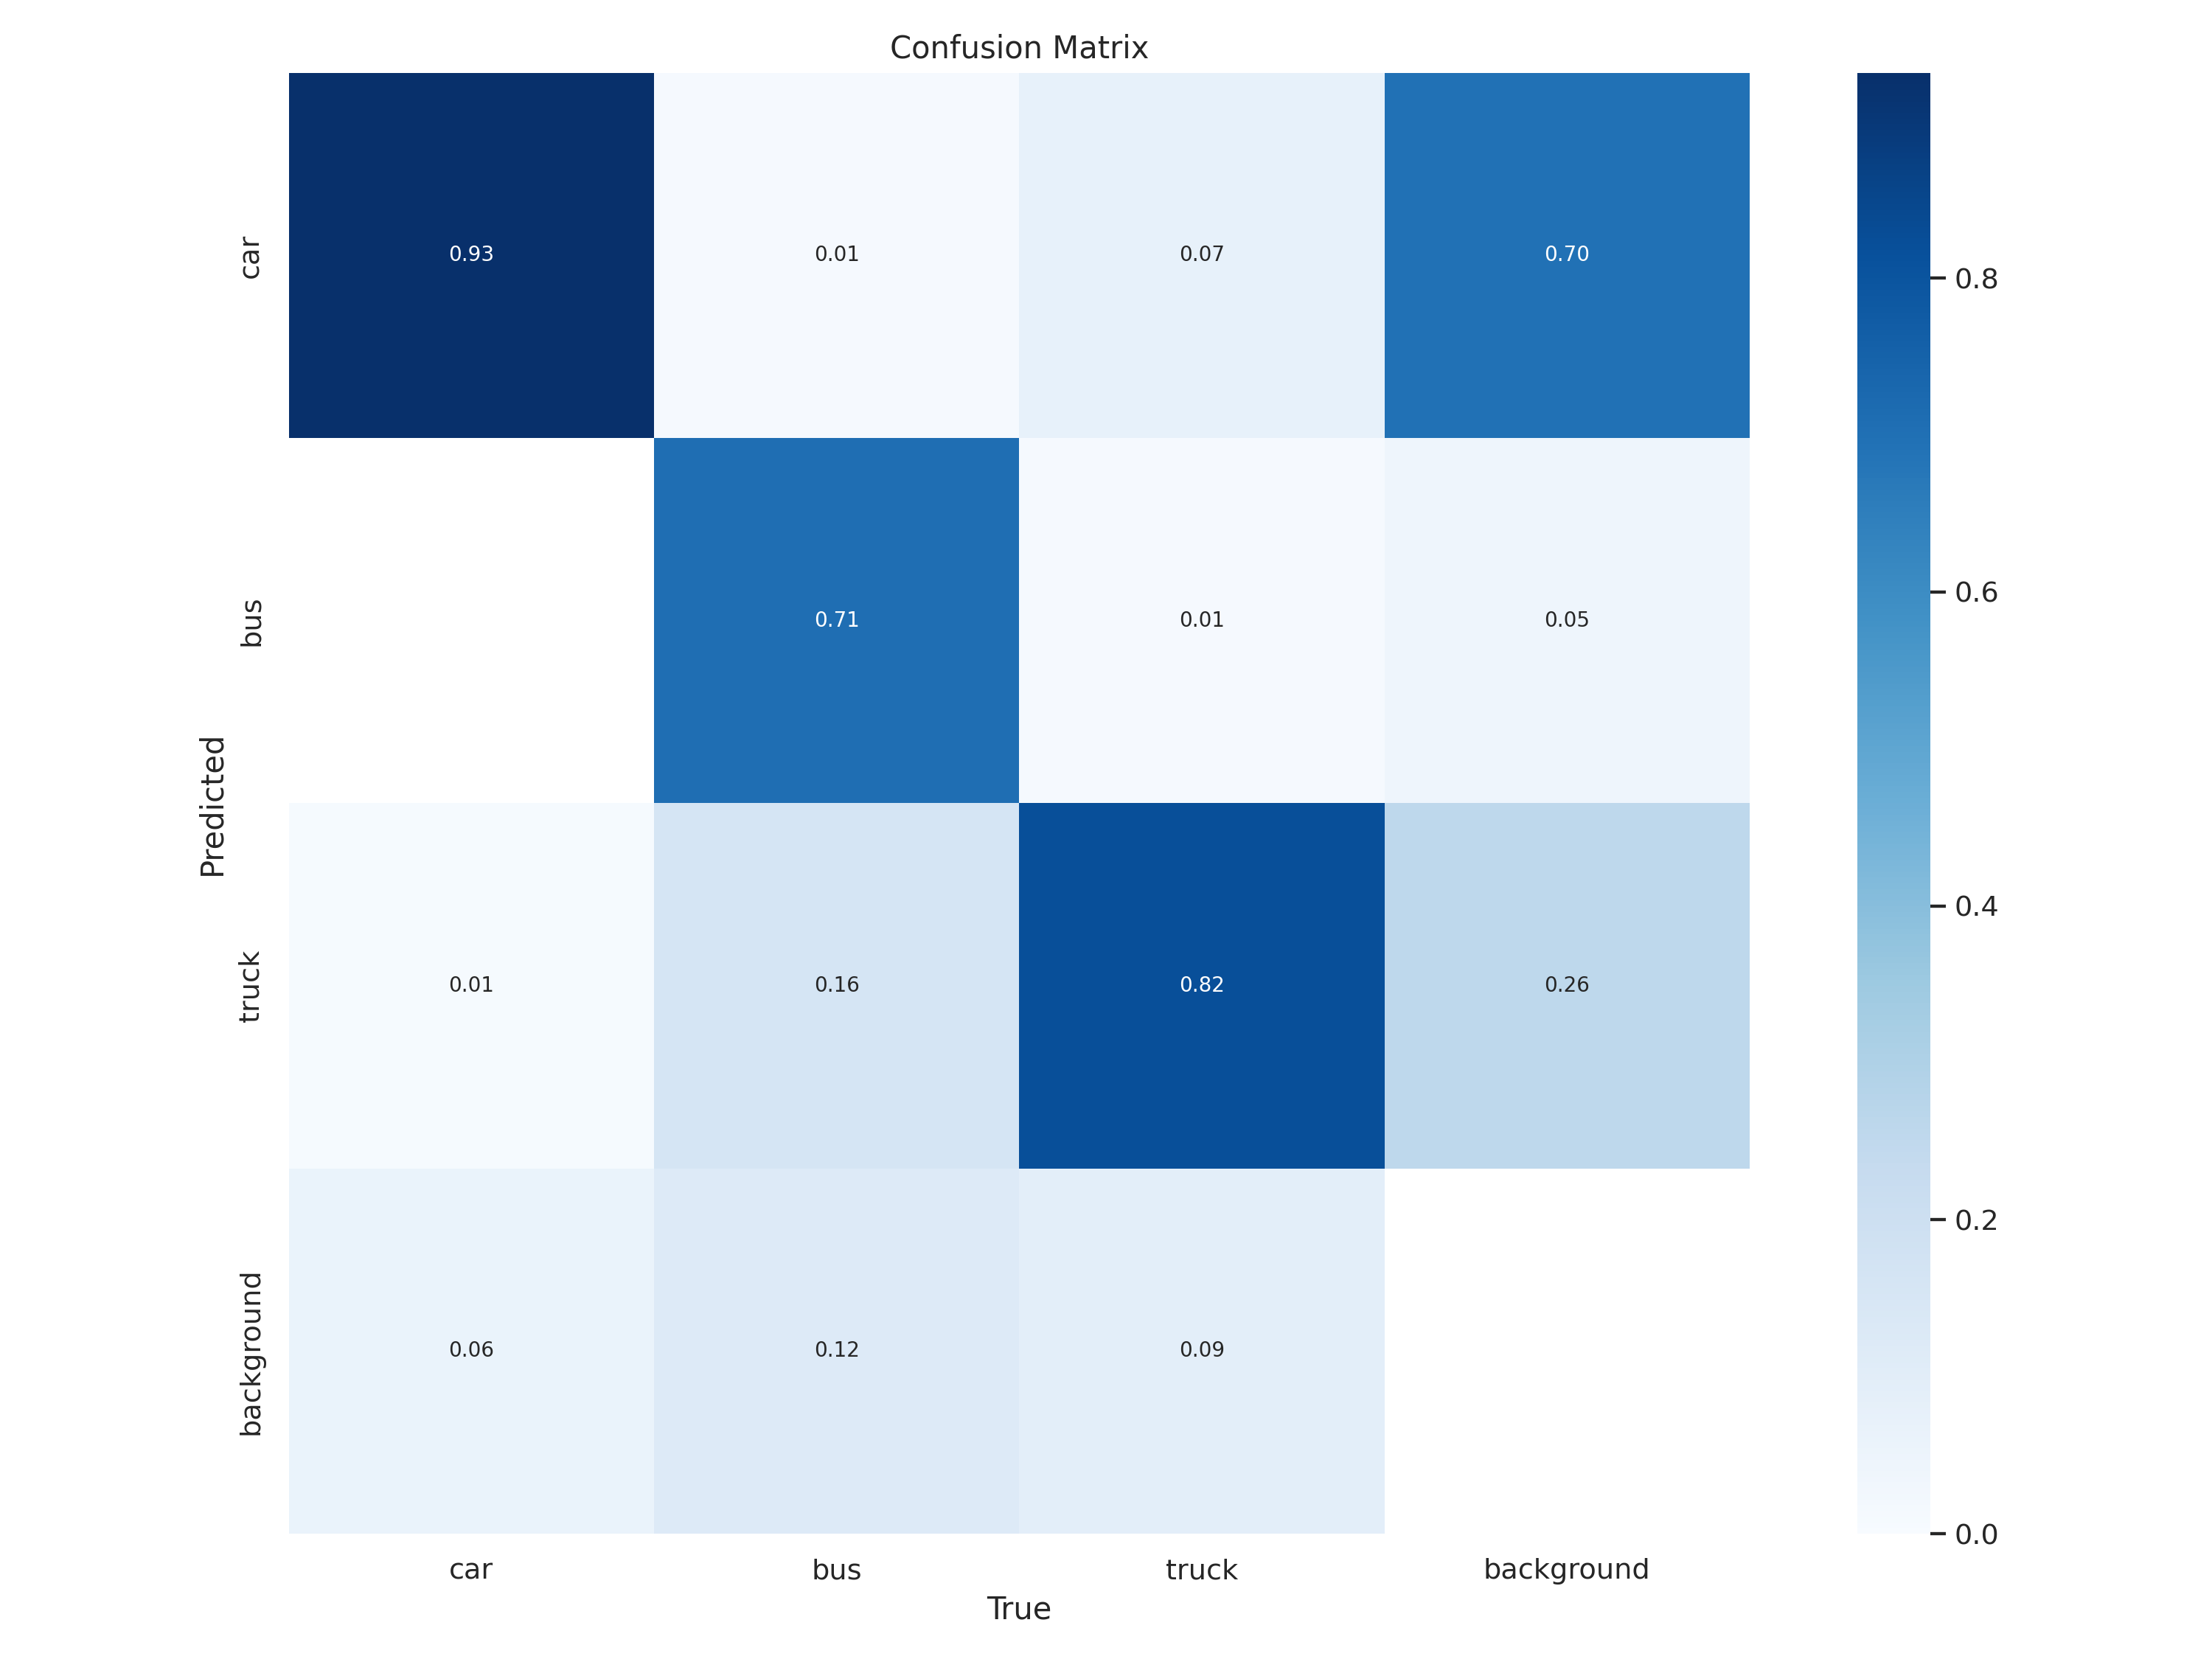

In [64]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train5/confusion_matrix.png', width=1200)

/home/jupyter


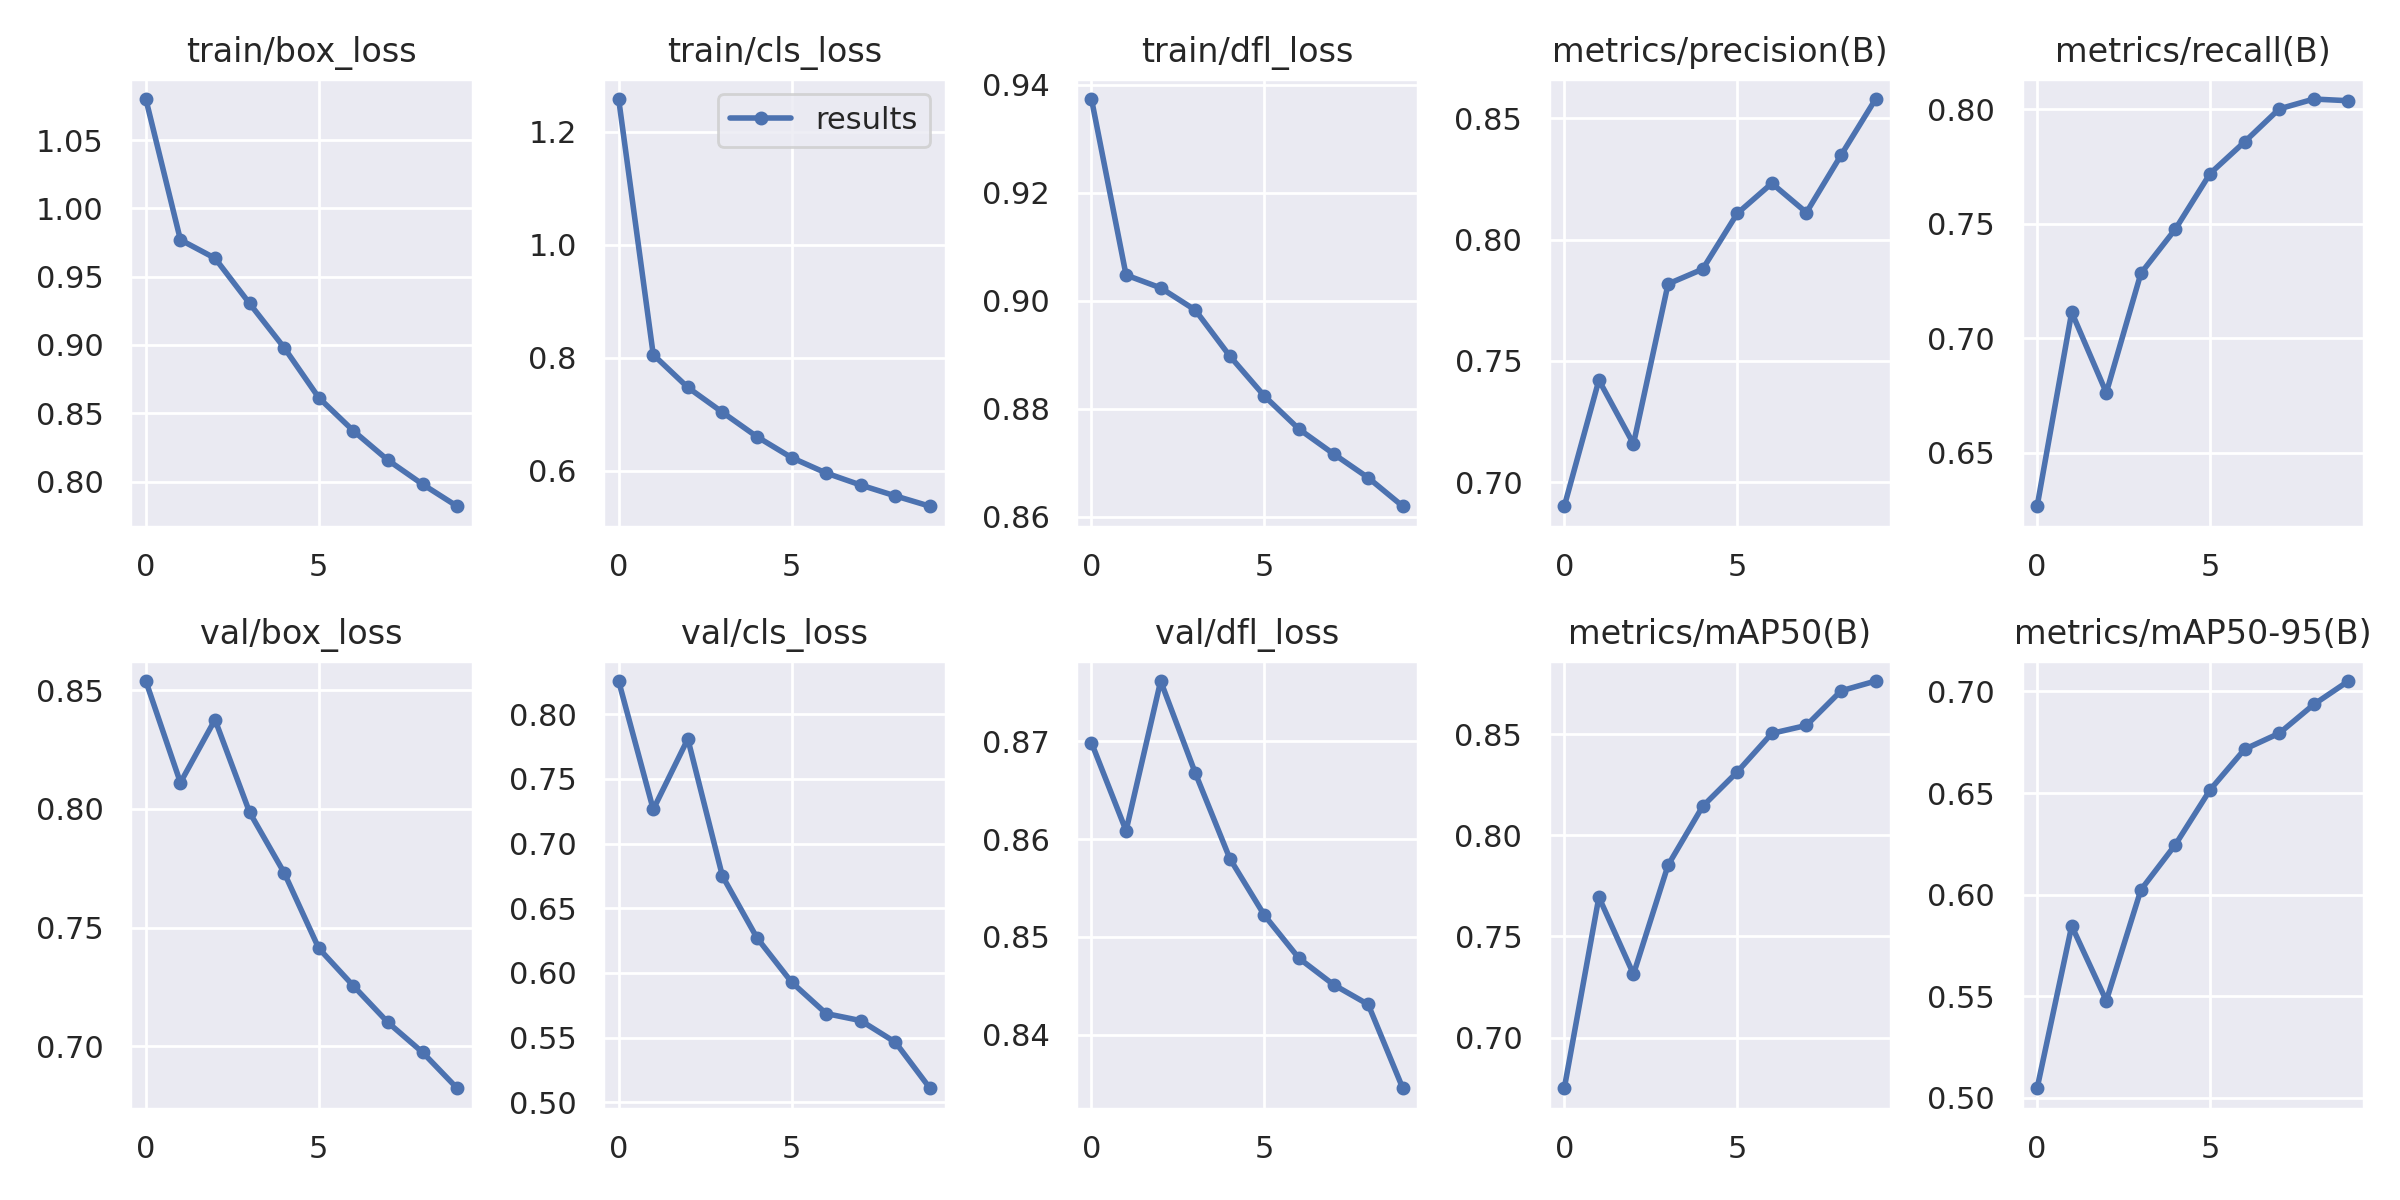

In [66]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train5/results.png', width=1200)

In [47]:
import os
os.getcwd()

'/home/jupyter'

In [53]:
testImages = HOME+'/dataset/valid/images'
from glob import glob

testList =[]
for filename in glob(os.path.join(testImages, '*.png')):
    testList.append(filename)

In [54]:
testList

['/home/jupyter/dataset/valid/images/Suwon_CH03_20200720_2030_MON_9m_NH_highway_OW5_sunny_FHD_027.png',
 '/home/jupyter/dataset/valid/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highway_OW5_sunny_FHD_138.png',
 '/home/jupyter/dataset/valid/images/Suwon_CH02_20200720_2130_MON_9m_NH_highway_TW5_sunny_FHD_011.png',
 '/home/jupyter/dataset/valid/images/Suwon_CH02_20200720_2130_MON_9m_NH_highway_TW5_sunny_FHD_099.png',
 '/home/jupyter/dataset/valid/images/Suwon_CH04_20200722_1600_WED_9m_NH_highway_OW5_rainy_FHD_120.png',
 '/home/jupyter/dataset/valid/images/Suwon_CH01_20201213_1200_SUN_9m_NH_highway_TW5_snow_FHD_221.png',
 '/home/jupyter/dataset/valid/images/Suwon_CH02_20200721_2030_TUE_9m_NH_highway_TW5_sunny_FHD_100.png',
 '/home/jupyter/dataset/valid/images/Suwon_CH01_20200720_1830_MON_9m_RH_highway_TW5_sunny_FHD_090.png',
 '/home/jupyter/dataset/valid/images/Suwon_CH02_20201213_0933_SUN_9m_NH_highway_TW5_snow_FHD_222.png',
 '/home/jupyter/dataset/valid/images/Suwon_CH02_20200721_2030_TUE_

In [59]:
len(testList)

3183

In [70]:
from ultralytics import YOLO

resultList =[]

# Load a pretrained YOLOv8n model
model = YOLO(HOME+'/runs/detect/train5/weights/best.pt')

# Run inference on images
results = model(testList)

# View results
for result in results:
    resultList.append(result.cpu().numpy().boxes.cls)  # print the Boxes object containing the detection bounding boxes

Ultralytics YOLOv8.0.20 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40354MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


AssertionError: Expected PIL/np.ndarray image type, but got <class 'str'>

In [56]:
import pandas as pd
sum = [0, 0, 0]

for result in resultList:
    for i in range(len(sum)):
        sum[i] += result.tolist().count(i)
print(sum)

print("전체 {}장의 이미지에서 승용차 {}대, 버스 {}대, 트럭 {}대를 발견하였습니다.".format(len(resultList), sum[0], sum[1], sum[2]))

[0, 0, 0]
전체 0장의 이미지에서 승용차 0대, 버스 0대, 트럭 0대를 발견하였습니다.
